## Analyzing Beer Reviews

In [1]:
from pyspark.sql import SparkSession
from pylab import plot, show
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import coo_matrix
import json

spark = SparkSession.builder.appName("mnist").getOrCreate()
df = spark.read.json('/beer_review/labeled.json')
#df.show()


## Data Inspection

Statistical Summary of Entire Dataset

In [2]:
median = df.stat.approxQuantile("overall", [0.5], 0.01)[0]
print "The median of overall rating is %.1f" % median
df.describe("overall").show()

The median of overall rating is 14.0
+-------+------------------+
|summary|           overall|
+-------+------------------+
|  count|           2486348|
|   mean|13.198879641948754|
| stddev| 3.352351483320109|
|    min|               1.0|
|    max|              20.0|
+-------+------------------+



Computing median, mean, standard deviation of each brewer and beer

In [3]:
brewer_stats = df.rdd.map(lambda x: (x["brewer"], x["overall"])) \
               .groupByKey().mapValues(list) \
               .map(lambda x: (x[0], {"median" : np.median(x[1]),"mean" : np.mean(x[1]),"std" : np.std(x[1])})).collect()

beer_stats = df.rdd.map(lambda x: (x["beer_name"], x["overall"])) \
               .groupByKey().mapValues(list) \
               .map(lambda x: (x[0], {"median" : np.median(x[1]),"mean" : np.mean(x[1]),"std" : np.std(x[1])})).collect()

Results separated by brewer:

In [4]:
def prn(x):
    print "%d --- %.2f --- %.2f --- %.2f" % (x[0], x[1]["median"], x[1]["mean"], x[1]["std"])

print "Brewer --- Median --- Mean --- Std. Dev."
# map(lambda x: prn(x), brewer_stats)
temp = map(lambda x: prn(x), brewer_stats[0:20])


Brewer --- Median --- Mean --- Std. Dev.
0 --- 13.00 --- 12.84 --- 2.54
3584 --- 12.00 --- 11.28 --- 3.03
4228 --- 11.00 --- 9.33 --- 3.77
5124 --- 14.00 --- 13.59 --- 2.42
3836 --- 13.00 --- 12.65 --- 2.39
3080 --- 11.00 --- 10.90 --- 2.31
1708 --- 2.50 --- 2.50 --- 0.50
1036 --- 14.00 --- 13.57 --- 1.40
3780 --- 14.00 --- 14.00 --- 0.00
2576 --- 10.00 --- 9.31 --- 2.27
7000 --- 11.00 --- 11.00 --- 0.82
4116 --- 12.00 --- 11.42 --- 1.98
2072 --- 15.00 --- 14.95 --- 2.00
3332 --- 13.00 --- 12.55 --- 2.08
1316 --- 13.00 --- 12.88 --- 2.46
2380 --- 13.00 --- 12.67 --- 1.86
7196 --- 14.00 --- 13.53 --- 1.48
1568 --- 12.00 --- 9.80 --- 3.12
6832 --- 13.50 --- 13.50 --- 0.96
700 --- 14.00 --- 13.57 --- 2.32


Results separated by beer:

In [5]:
def prn2(x):
    print "%s --- %.2f --- %.2f --- %.2f" % (x[0], x[1]["median"], x[1]["mean"], x[1]["std"])
    
print "Beer --- Median --- Mean --- Std. Dev."
# map(lambda x: prn2(x), beer_stats)
temp = map(lambda x: prn2(x), beer_stats[0:20])


Beer --- Median --- Mean --- Std. Dev.
Naylors Mothers Best --- 11.00 --- 11.33 --- 0.47
Reddaways Devon Cider &#40;Bottle&#41; --- 11.00 --- 11.00 --- 1.00
Brew Moon Eclipse Extra Stout --- 17.00 --- 17.00 --- 0.00
Bastone Main Street Pilsener --- 13.00 --- 12.87 --- 1.67
Martinborough White Rock Wheat --- 12.50 --- 12.00 --- 3.37
John Harvards Hop Chronic IPA --- 10.50 --- 10.50 --- 2.50
Big Bear Schwarzbier --- 15.00 --- 15.00 --- 0.00
Wellington Silver Wheat Ale --- 10.00 --- 9.58 --- 2.40
Grosswald Pilsener --- 8.00 --- 8.00 --- 1.00
Jamesport Scottish Strong Ale --- 11.00 --- 11.40 --- 1.02
Foxfield Sonic Damson --- 15.00 --- 15.00 --- 0.00
Devils Backbone Turbo Cougar 2011 --- 14.00 --- 14.00 --- 0.00
Buffalo Maibock --- 13.00 --- 13.00 --- 1.00
New Albanian Scalawag Saison --- 14.00 --- 14.00 --- 0.71
Swashbuckler Plankwalkers IPA --- 14.00 --- 13.88 --- 1.36
Corner Cafe Bohemian Pilsener --- 12.00 --- 12.00 --- 0.00
Grumpy Troll Downtown Brown Ale --- 13.00 --- 13.50 --- 0.87


Although the mean and median greatly vary among each brewer and each beer,tTo determine whether or not people have 
similar taste, we examine the standard deviation of each brewer and each beer. They are generally well below 3, 
which is reasonably small to me. That means that the consumers of a given brewer or beer generally rate the 
beer around the same range. Based on this fact, I will argue that the consumers have similar taste, but this is biased
by the fact that the reviewers will not purchase beer that he/she dislikes in the first place. On the other hand,
people who have strong opinions are also more likely to leave a review. Therefore, overall, I do believe
people have similar taste.

## Sentiment Analysis

(1) Generating Features

In [6]:
import string

with open('/project/cmsc25025/beer_review/vocab_50.json', 'r') as f:
    vocab = json.load(f) # list of unique 30,009 words of interest
 
l = len(vocab)

In [7]:
def data_counter(s):
    # Parse reviews into an array of lower-case words
    ws = set(s.encode('utf-8').lower().translate(string.maketrans("",""), string.punctuation).split())
    # for each word, check if it exists in the vocab
    # if so, record its value
    return [vocab[w] for w in ws if (w in vocab)]

train, valid, test = df.rdd.repartition(28 * 4) \
                           .map(lambda x: (1 if float(x["overall"]) >= 14 else 0, data_counter(x["review"]))) \
                           .filter(lambda line: line[1] != []) \
                           .map(lambda x: (x[0], coo_matrix((np.ones(len(x[1])),(np.zeros(len(x[1])),x[1])), shape=(1,l)))).cache() \
                           .randomSplit([0.7,0.15,0.15])
                

The features generated above uses the given vocabulary of 30,009 words that appeared at least 50 times across all the reviews.
Each row represents a review that contained at least contain at least a word from the vocabulary. Within the row is a tuple, 
the first term being binary (0 negtiave/1 positive) of the type of review. The second term is 1 x 30,009 sparse matrix, 
where a column is marked 1 if the word has appeared in the review, and 0 if the word does not.

(2) Stochastic Gradient Descent

Training with Mini-Batch:

In [9]:
from operator import add
from time import time

# try batch size of 500 to 1000
batch_size = 10000 # 500, 1000, 1500, 10000
n_batch = 1736713/batch_size # nubmer of batches = aprrox. number of reviews divided by batch_size

beta = spark.sparkContext.broadcast(np.zeros(l))
c_1 = 0.01
c_2 = 0.35
# learning_rate = c1 / t ^ c^2
ld = 0.0005 # lambda

likelihood = [] # negative log-likelihood
error_rates = [] # error rate per batch

n_valid = 372349
likelihood_valid = [] 
error_rates_valid = [] 

def compute_grad(x,b):
    # y = x[0], x = x[1], y_hat = x[1].dot(beta)[0]
    pi = 1/(1+np.exp(x[1].dot(-b)[0]))
    y_hat = 1 if pi >= 0.5 else 0
    er = 1 if y_hat != x[0] else 0 # error
    grad = (x[0] - pi) * x[1]
    npi = -1.0 * np.log(pi ** x[0] * (1 - pi) ** (1 - x[0]))
    return (npi, er, grad)

def validate(x,b):
    pi = 1/(1+np.exp(x[1].dot(-b)[0]))
    y_hat = 1 if pi >= 0.5 else 0
    er = 1 if y_hat != x[0] else 0
    npi = -1.0 * np.log(pi ** x[0] * (1 - pi) ** (1 - x[0]))
    return (npi, er)

# epoch loop
n_epoch = 10 # 10
for e in range(1,n_epoch + 1):
    # print "epoch: %d" % e
    batches = train.randomSplit(np.ones(n_batch))
    for t in range(0,n_batch):
        start = time()
#         print "iter: %d" % t
        learning_rate = c_1 / (((e-1)*n_batch + (t+1)) ** c_2)
        npi_500, er_500, grad_500 = batches[t].map(lambda x: compute_grad(x,beta.value)) \
                                              .reduce(lambda (p1, e1, g1), (p2, e2, g2): (p1+p2,e1+e2,g1+g2))
        update = learning_rate * (grad_500.toarray()[0] - ld * beta.value)
        beta = spark.sparkContext.broadcast(beta.value + update)

        # update likelihood
        likelihood.append(npi_500)
        # update error
        error_rates.append(er_500/float(batch_size))
        
#         print time() - start
        
        # Validation
        npi_v, er_v = valid.map(lambda x: validate(x,beta.value)) \
                           .reduce(lambda (p1, e1), (p2, e2): (p1+p2,e1+e2))
        
        likelihood_valid.append(npi_v) 
        error_rates_valid.append(er_v / float(n_valid))
        
#         print time() - start
        
print "Finished"

Finished


In my implementation of logistic regression with stochastic gradient descent, I use a batch size of 10,000 reviews. With 1,736,713 reviews in the training set, this results in 173 batches, each batch requires 1.5 seconds to train and 1.5 seconds to validate with caching. For each epoch, I randomly split the training set into 173 batches and train with all of them, requiring about 9 minutes to train an epoch. My final training had ten epochs (though a smaller number of epoch would have been sufficient and perhaps I should have chosen a smaller batch size). The lambda value that minimizes our validation error is 0.005, and we use in our regularizer.



In [41]:
# print beta.value
# beta_save = beta.value
# likelihood_save = likelihood # from first run with 1 epoch
# error_rates_save = error_rates # from first run with 1 epoch
# print likelihood
# print error_rates
# print beta_save

Plots:

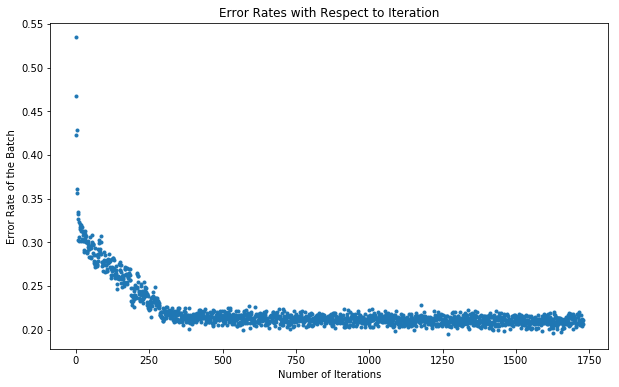

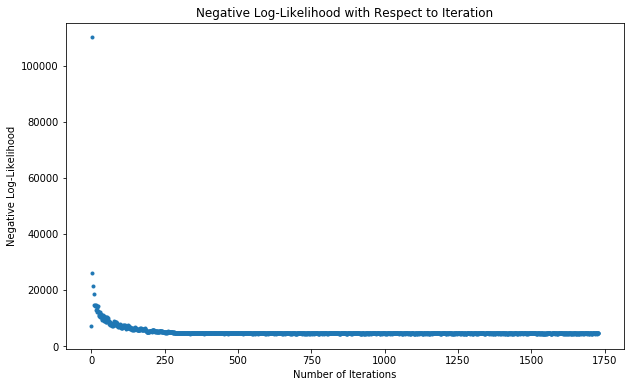

In [12]:
plt.figure(figsize=(10,6))
plt.plot(range(n_epoch*n_batch), error_rates, '.')
plt.title('Error Rates with Respect to Iteration')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Rate of the Batch')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(n_epoch*n_batch), likelihood, '.')
plt.title('Negative Log-Likelihood with Respect to Iteration')
plt.xlabel('Number of Iterations')
plt.ylabel('Negative Log-Likelihood')
plt.show()

Validation:

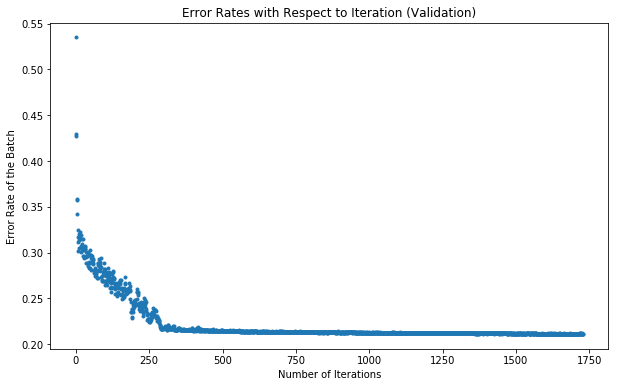

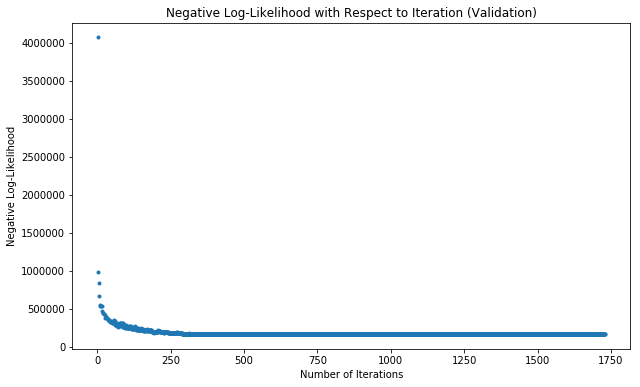

In [13]:
plt.figure(figsize=(10,6))
plt.plot(range(n_epoch*n_batch), error_rates_valid, '.')
plt.title('Error Rates with Respect to Iteration (Validation)')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Rate of the Batch')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(n_epoch*n_batch), likelihood_valid, '.')
x1,x2,y1,y2 = plt.axis()
plt.title('Negative Log-Likelihood with Respect to Iteration (Validation)')
plt.axis([x1,x2,y1,y2])
plt.xlabel('Number of Iterations')
plt.ylabel('Negative Log-Likelihood')
plt.show()

## Prediction using Scores

In the dataset, there are various scores on the beer's appearance, aroma, palate, style, taste. I will try to use those to predict the overall score rather than using the text.

In [88]:
train_s, valid_s, test_s = df.rdd.repartition(28 * 4) \
                                 .map(lambda x: (1 if float(x["overall"]) >= 14 else 0, 
                                                 np.array([[x["appearance"], x["aroma"], x["palate"], x["style"], x["taste"]]]))).cache() \
                                 .randomSplit([0.7,0.15,0.15])

Training with Mini-Batch:

In [140]:
batch_size = 10000 # 500, 1000, 1500, 10000
n_batch = 1736713/batch_size # nubmer of batches = aprrox. number of reviews divided by batch_size

beta_score = spark.sparkContext.broadcast(np.zeros(5))
c_1 = 0.001
c_2 = 1.35 
# learning_rate = c1 / t ^ c^2
ld_score2 = 0.0002 # lambda

likelihood_score = [] # negative log-likelihood
error_rates_score = [] # error rate per batch

n_valid = 372349
likelihood_valid_score = [] 
error_rates_valid_score = [] 

# epoch loop
n_epoch = 1 # 10
for e in range(1,n_epoch + 1):
    # print "epoch: %d" % e
    batches = train_s.randomSplit(np.ones(n_batch))
    for t in range(0, n_batch):
        start = time()
#         print "iter: %d" % t
        learning_rate = c_1 / (((e-1)*n_batch + (t+1)) ** c_2)
        npi_500, er_500, grad_500 = batches[t].map(lambda x: compute_grad(x,beta_score.value)) \
                                              .reduce(lambda (p1, e1, g1), (p2, e2, g2): (p1+p2,e1+e2,g1+g2))
        # print npi_500, er_500, grad_500
        update = learning_rate * (grad_500[0] - ld_score2 * beta_score.value)
        beta_score = spark.sparkContext.broadcast(beta_score.value + update )
#         print beta_score.value
        # update likelihood
        likelihood_score.append(npi_500)
        # update error
        error_rates_score.append(er_500/float(batch_size))
#         print (er_500/float(batch_size))
#         print time() - start
        
        # Validation
        npi_v, er_v = valid_s.map(lambda x: validate(x,beta_score.value)) \
                             .reduce(lambda (p1, e1), (p2, e2): (p1+p2,e1+e2))
        
        likelihood_valid_score.append(npi_v) 
        error_rates_valid_score.append(er_v / float(n_valid))
        
#         print time() - start
        
print "Finished"

Finished


In my implementation of logistic regression with stochastic gradient descent, I use a batch size of 10,000 reviews. With 1,736,713 reviews in the training set, this results in 173 batches, each batch requires 0.5 seconds to train and 0.5 seconds to validate with caching. For each epoch, I randomly split the training set into 173 batches and train with all of them. My final training had 1 epochs (perhaps I should have chosen a smaller batch size). The lambda value that minimizes our validation error is 0.0002, and we use in our regularizer.



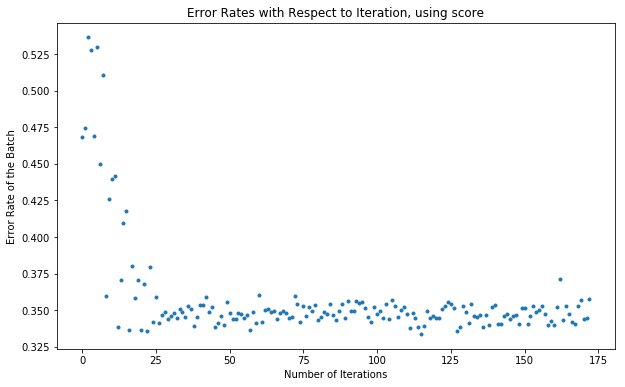

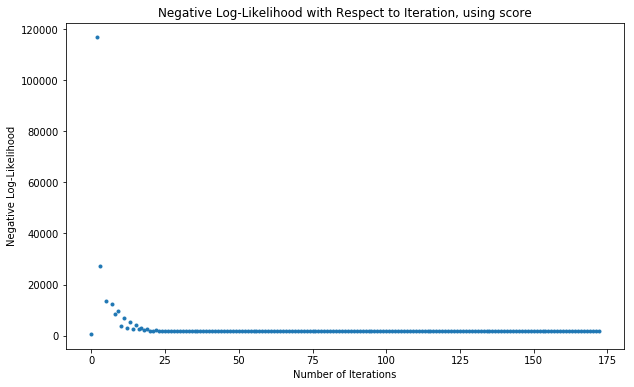

In [147]:
plt.figure(figsize=(10,6))
plt.plot(range(n_epoch*n_batch), error_rates_score, '.')
plt.title('Error Rates with Respect to Iteration, using score')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Rate of the Batch')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(n_epoch*n_batch), likelihood_score, '.')
x1,x2,y1,y2 = plt.axis()
plt.title('Negative Log-Likelihood with Respect to Iteration, using score')
plt.axis([x1,x2,y1,y2])
plt.xlabel('Number of Iterations')
plt.ylabel('Negative Log-Likelihood')
plt.show()

Validation:

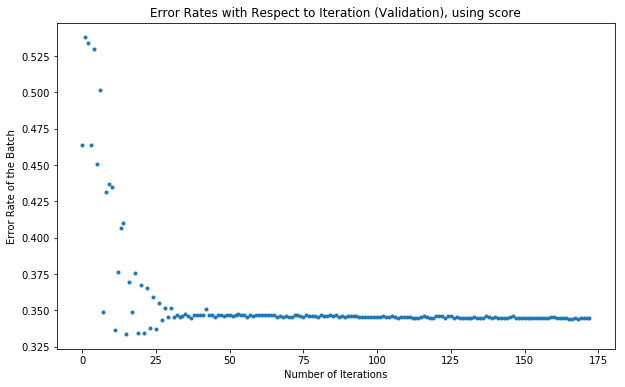

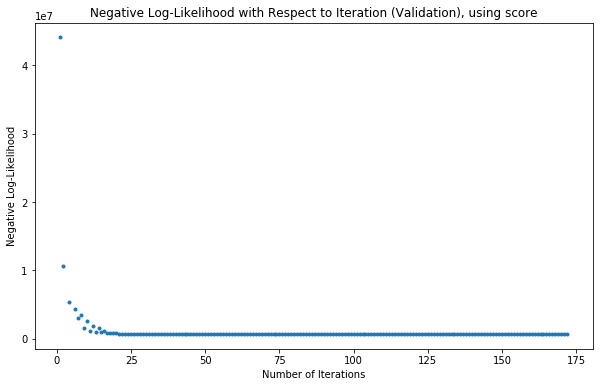

In [148]:
plt.figure(figsize=(10,6))
plt.plot(range(n_epoch*n_batch), error_rates_valid_score, '.')
plt.title('Error Rates with Respect to Iteration (Validation), using score')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Rate of the Batch')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(n_epoch*n_batch), likelihood_valid_score, '.')
x1,x2,y1,y2 = plt.axis()
plt.title('Negative Log-Likelihood with Respect to Iteration (Validation), using score')
plt.axis([x1,x2,y1,y2])
plt.xlabel('Number of Iterations')
plt.ylabel('Negative Log-Likelihood')
plt.show()

Comparison between score and text model

After hours of training, the score model has a validation error rate of 35% and text model has a final validation error rate around lower 20s%, so the performance of text model is better than the score model as we can see from plots above. The difference is: the scores model only utilize raw features, whereas the text model requires us to parse the reviews and create our own features. This tells me that the scores model is more simple, easy, and quick to use, while the text model is more complex to build but perhaps has more room for improvements if we were able to create very clever features. The text model also faces the issue when the reviews do not contain any words from the vocabulary, and in that case, we do not know how to classify at all.

In [ ]:
# Saving the results
# beta_words = beta.value
# beta_s = beta_score.value

# with open('beta_words.json', 'w') as f:
#     json.dump(beta_words.tolist(), f)
    
# with open('beta_score.json', 'w') as f:
#     json.dump(beta_s.tolist(), f)

## Building a new linear classifier to experiment

In [40]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint
from random import randint

unl = spark.read.json('/project/cmsc25025/beer_review/unlabeled.json')
from pyspark.mllib.regression import LabeledPoint
# unl.show()

+----------+-----+-------+--------------------+------+------+--------------------+---------+-----+-----+
|appearance|aroma|beer_id|           beer_name|brewer|palate|              review|review_id|style|taste|
+----------+-----+-------+--------------------+------+------+--------------------+---------+-----+-----+
|       2.0|  4.0|  65957|John Harvards Fan...|  3084|   2.0|On tap at the Spr...|        4|   33|  4.0|
|       4.0|  5.0|  19708|John Harvards Dr....|  3084|   4.0|From Springfield ...|       12|   60|  7.0|
|       3.0|  6.0|  21566|Barley Island Bar...|  1786|   3.0|GTMW 08 on cask -...|       19|   66|  6.0|
|       3.0|  7.0| 108906|Barley Island Dir...|  1786|   3.0|Handbottled, cour...|       25|   57|  7.0|
|       4.0|  7.0| 108906|Barley Island Dir...|  1786|   3.0|Bottled. Amber co...|       30|   57|  7.0|
|       3.0|  8.0| 108906|Barley Island Dir...|  1786|   4.0|Had this on tap l...|       35|   57|  9.0|
|       4.0|  6.0|  72141|Barley Island Sin...|  1786| 

In [158]:
l2 = unl.count()

# new_train, new_valid = df.rdd.map(lambda x: LabeledPoint(1 if x["overall"] >= 14 else 0, 
#                                               [x["appearance"], x["aroma"], x["palate"], x["style"], x["taste"]])).cache() \
#                          .randomSplit([9,1])

test_text = df.rdd.map(lambda x: data_counter(x["review"])) \
                  .map(lambda x: [randint(0, 30009)] if x == [] else x) \
                  .map(lambda x: (coo_matrix((np.ones(len(x)),(np.zeros(len(x)),x)), shape=(1,l)))).cache() \

test_score = df.rdd.map(lambda x: np.array([x["appearance"], x["aroma"], x["palate"], x["style"], x["taste"]])).cache()

test_labels = df.rdd.map(lambda x: 1 if x["overall"] >= 14 else 0).cache().collect()

unl_text = unl.rdd.map(lambda x: data_counter(x["review"])) \
                  .map(lambda x: [randint(0, 30009)] if x == [] else x) \
                  .map(lambda x: (coo_matrix((np.ones(len(x)),(np.zeros(len(x)),x)), shape=(1,l)))).cache() \

unl_score = unl.rdd.map(lambda x: np.array([x["appearance"], x["aroma"], x["palate"], x["style"], x["taste"]])).cache()

Building the model:

In [169]:
def new_pred(x,b):
    pi = 1/(1+np.exp(x.dot(-b)[0]))
    return pi
def new_pred2(x,b):
    pi = 1/(1+np.exp(x.dot(-b)))
    return pi

# temp1 = test_text.map(lambda x: new_pred(x,beta_words)).collect()
# temp2 = test_score.map(lambda x: new_pred2(x,beta_s)).collect()
# total = np.add(temp1,temp2)
# preds = map(lambda x: 1 if x >= 1 else 0 ,total)

temp1 = unl_text.map(lambda x: new_pred(x,beta_words)).collect()
temp2 = unl_score.map(lambda x: new_pred2(x,beta_s)).collect()
total = np.add(temp1,temp2)
preds = map(lambda x: 1 if x >= 1 else 0 ,total)


In [27]:
# testing using packages
# model1 = SVMWithSGD.train(data = new_train, iterations=1000, miniBatchFraction = 0.1)

# # Evaluating the model on training data
# labelsAndPreds = new_train.map(lambda p: (p.label, model1.predict(p.features)))
# trainErr1 = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(new_train.count())
# print("Training Error = " + str(trainErr1))

Training Error = 0.427650394274


In [174]:
# model2 = LogisticRegressionWithLBFGS.train(data = new_train, iterations = 100, numClasses=2, initialWeights = beta_s)

# labelsAndPreds = new_train.map(lambda p: (p.label, model2.predict(p.features)))
# trainErr2 = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(new_train.count())
# print("Training Error = " + str(trainErr2))

Training Error = 0.313756386361


In our approach, using the weights obtained from part 2 and 3, we use the five score variables to get a prediction value from 0 to 1, and we use the text to get a prediction value from 0 to 1. We then add them together, and predict positive (1) if the sum is greater than or eqaul to 1, and negative (0) if the sum is less than 1.

Writing out results:

In [ ]:
with open('assn3_prob4_predict.json', 'w') as f:
    json.dump(preds, f)